**Task 1. Basic image colorization**.
Description: Implement a simple model that colorizes grayscale photos using basic deep learning techniques. Guidelines: Build the model with Python and a deep learning framework such as TensorFlow or Keras. Concentrate on getting the model to generate observable colorization results. GUI is not necessary.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())

else:
  print("Using CPU")

0


Here below i did data augmentation part

In [3]:
transform_augment = transforms.Compose([

    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),  # Random rotation between -30 and +30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),  # Convert to tensor

])

transform = transforms.Compose([

    transforms.ToTensor(),

])

# Load the datasets
train_dataset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_augment)
train_loader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 29835684.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

In [5]:
model = ColorizationNet().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert RGB image to grayscale
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

In [6]:
EPOCHS = 30
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader_augmented):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        # Forward pass

        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader_augmented)}], Loss: {loss.item():.4f}")

print("Finished Training")

Epoch [1/30], Step [1/782], Loss: 0.0900
Epoch [1/30], Step [101/782], Loss: 0.0085
Epoch [1/30], Step [201/782], Loss: 0.0042
Epoch [1/30], Step [301/782], Loss: 0.0043
Epoch [1/30], Step [401/782], Loss: 0.0052
Epoch [1/30], Step [501/782], Loss: 0.0040
Epoch [1/30], Step [601/782], Loss: 0.0044
Epoch [1/30], Step [701/782], Loss: 0.0053
Epoch [2/30], Step [1/782], Loss: 0.0044
Epoch [2/30], Step [101/782], Loss: 0.0057
Epoch [2/30], Step [201/782], Loss: 0.0061
Epoch [2/30], Step [301/782], Loss: 0.0058
Epoch [2/30], Step [401/782], Loss: 0.0051
Epoch [2/30], Step [501/782], Loss: 0.0065
Epoch [2/30], Step [601/782], Loss: 0.0053
Epoch [2/30], Step [701/782], Loss: 0.0045
Epoch [3/30], Step [1/782], Loss: 0.0060
Epoch [3/30], Step [101/782], Loss: 0.0045
Epoch [3/30], Step [201/782], Loss: 0.0041
Epoch [3/30], Step [301/782], Loss: 0.0054
Epoch [3/30], Step [401/782], Loss: 0.0044
Epoch [3/30], Step [501/782], Loss: 0.0055
Epoch [3/30], Step [601/782], Loss: 0.0075
Epoch [3/30], Ste

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):

    img = img / 2 + 0.5
    npimg = img.numpy()
    if len(img.shape) == 2:
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):


    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        # Display original grayscale image
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        # Display colorized image
        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def torch_rgb_to_hsv(rgb):

    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val


    h = torch.zeros_like(r)
    mask = (max_val == r) & (g >= b)
    h[mask] = (g[mask] - b[mask]) / diff[mask]
    mask = (max_val == r) & (g < b)
    h[mask] = (g[mask] - b[mask]) / diff[mask] + 6.0
    mask = max_val == g
    h[mask] = (b[mask] - r[mask]) / diff[mask] + 2.0
    mask = max_val == b
    h[mask] = (r[mask] - g[mask]) / diff[mask] + 4.0
    h = h / 6.0
    h[diff == 0.0] = 0.0


    s = torch.zeros_like(r)
    s[diff != 0.0] = diff[diff != 0.0] / max_val[diff != 0.0]


    v = max_val

    return torch.stack([h, s, v], dim=1)


def torch_hsv_to_rgb(hsv):

    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = i % 6
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    r[i_mod == 0.0] = v[i_mod == 0.0]
    g[i_mod == 0.0] = t[i_mod == 0.0]
    b[i_mod == 0.0] = p[i_mod == 0.0]

    r[i_mod == 1.0] = q[i_mod == 1.0]
    g[i_mod == 1.0] = v[i_mod == 1.0]
    b[i_mod == 1.0] = p[i_mod == 1.0]

    r[i_mod == 2.0] = p[i_mod == 2.0]
    g[i_mod == 2.0] = v[i_mod == 2.0]
    b[i_mod == 2.0] = t[i_mod == 2.0]

    r[i_mod == 3.0] = p[i_mod == 3.0]
    g[i_mod == 3.0] = q[i_mod == 3.0]
    b[i_mod == 3.0] = v[i_mod == 3.0]

    r[i_mod == 4.0] = t[i_mod == 4.0]
    g[i_mod == 4.0] = p[i_mod == 4.0]
    b[i_mod == 4.0] = v[i_mod == 4.0]

    r[i_mod == 5.0] = v[i_mod == 5.0]
    g[i_mod == 5.0] = p[i_mod == 5.0]
    b[i_mod == 5.0] = q[i_mod == 5.0]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):


    images = (images + 1) / 2.0


    images_hsv = torch_rgb_to_hsv(images)


    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)


    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)


    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images

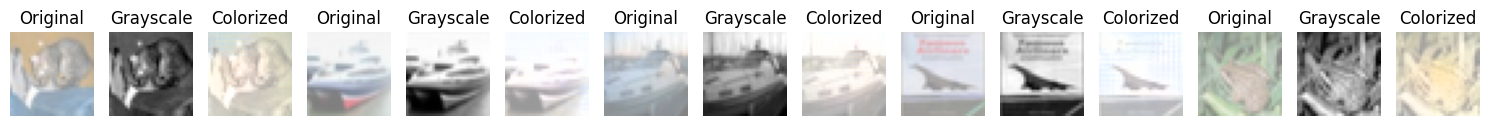

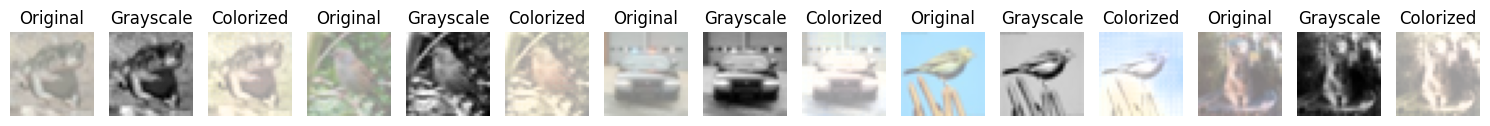

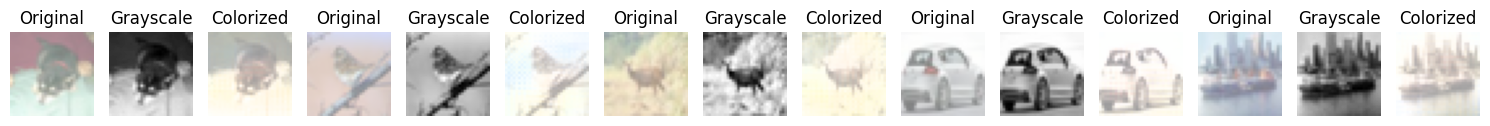

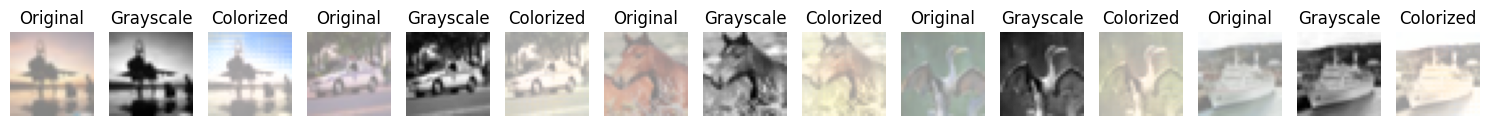

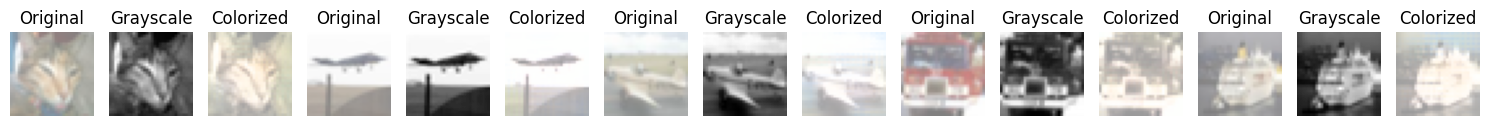

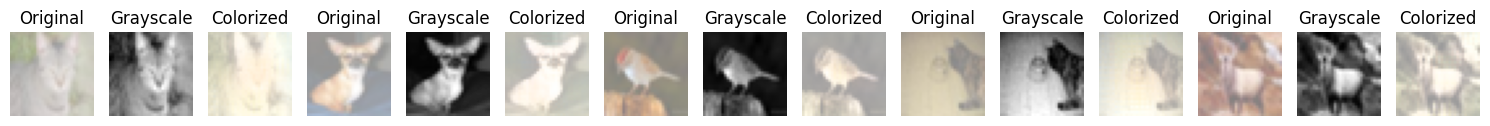

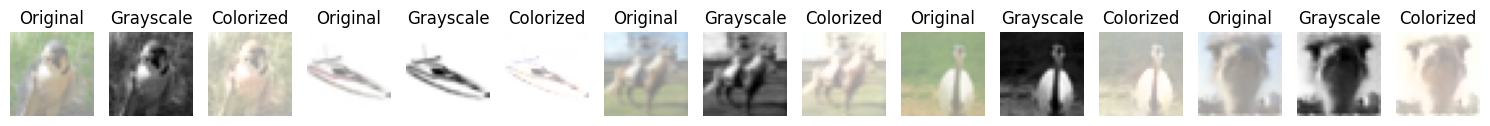

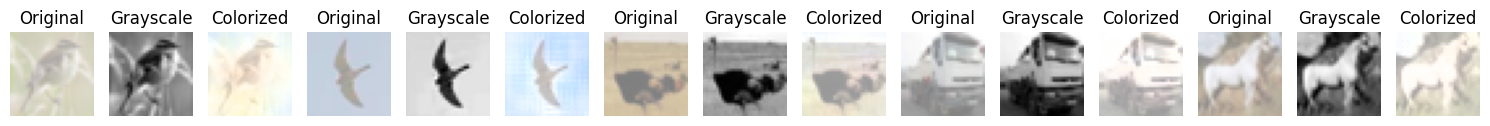

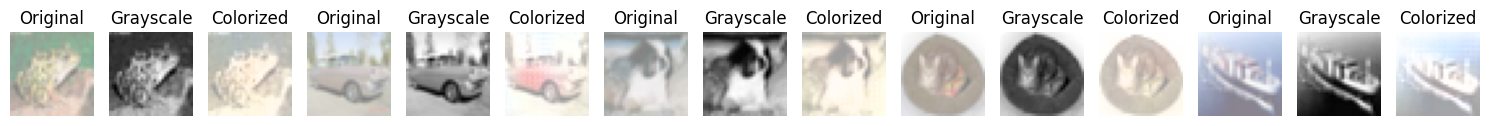

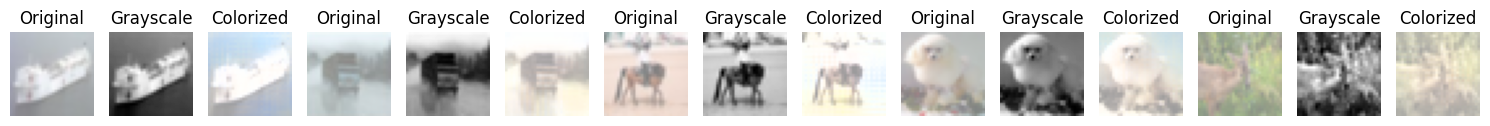

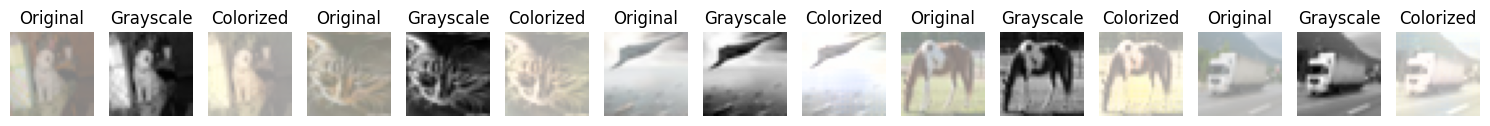

In [8]:
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        colorized_images = model(grayscale_images)


        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)
        colorized_images_cpu = colorized_images.cpu()
        original_images_cpu = images.cpu()


        colorized_images_cpu=exaggerate_colors(colorized_images_cpu)


        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

        if i == 10:
            break

In [9]:
import os


current_directory = os.getcwd()


print("Current working directory:", current_directory)

Current working directory: /content


In [10]:
from google.colab import files

# Upload files from your local machine
uploaded = files.upload()

# List the uploaded files
for filename in uploaded.keys():
    print("Uploaded file:", filename)

Saving Taj-Mahal-at-sunrise-4.jpeg to Taj-Mahal-at-sunrise-4.jpeg
Uploaded file: Taj-Mahal-at-sunrise-4.jpeg


In [11]:
import os

# List all files in the current directory
files = os.listdir("/content")
print("Files in the current directory:", files)

Files in the current directory: ['.config', 'Taj-Mahal-at-sunrise-4.jpeg', 'data', 'sample_data']


In [17]:
from PIL import Image


img = Image.open('/content/pexels-photo-372490.jpeg')


gray_img = img.convert("L")

In [18]:
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),

])

In [19]:
img_tensor = transform(gray_img).unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Move the image tensor to the device where your model is (likely 'cuda' if using GPU)
img_tensor = img_tensor.to(device)

# Get the model's output
with torch.no_grad():
    colorized_tensor = model(img_tensor)

In [20]:
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

# Optionally, save the image
colorized_img.save("_colorized2.jpg")

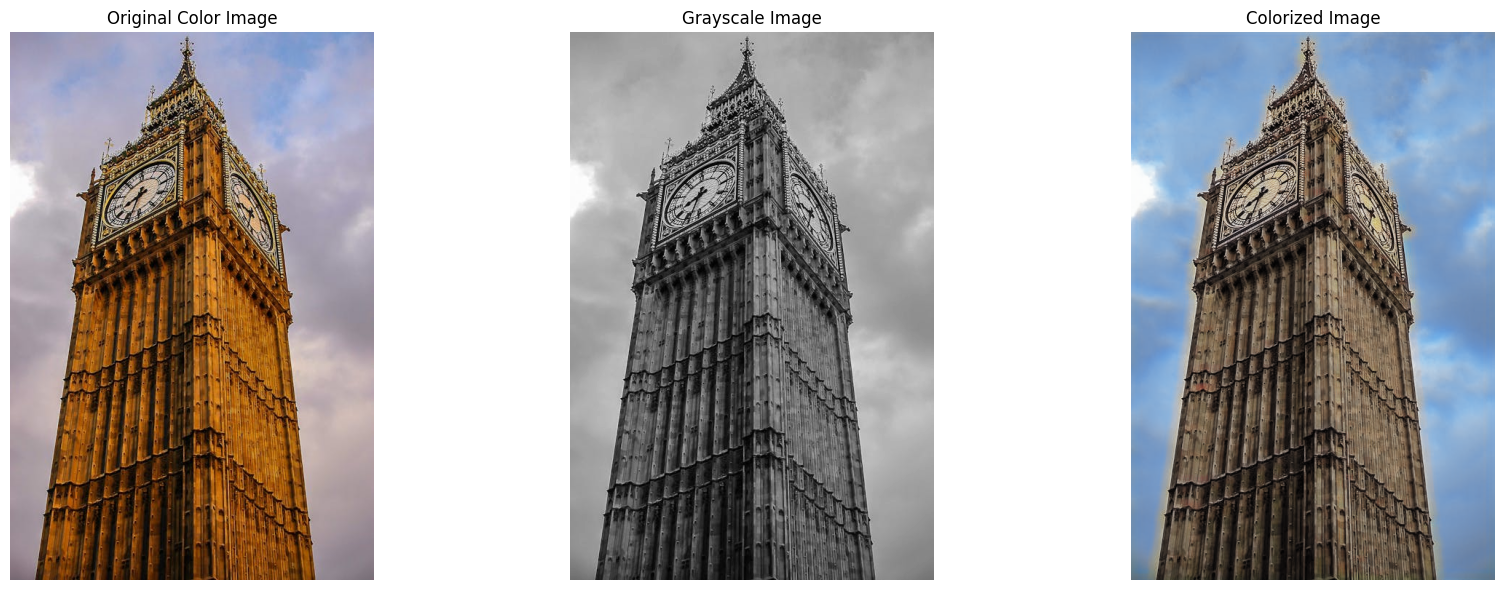

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))


ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')


ax[1].imshow(gray_img, cmap='gray')
ax[1].set_title("Grayscale Image")
ax[1].axis('off')


ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')

plt.tight_layout()
plt.show()

# **Training Loss Comparison**
Results Comparision of Task 1 and Task 2 by Graph of their loss during training.
Above you can already see the image output difference.

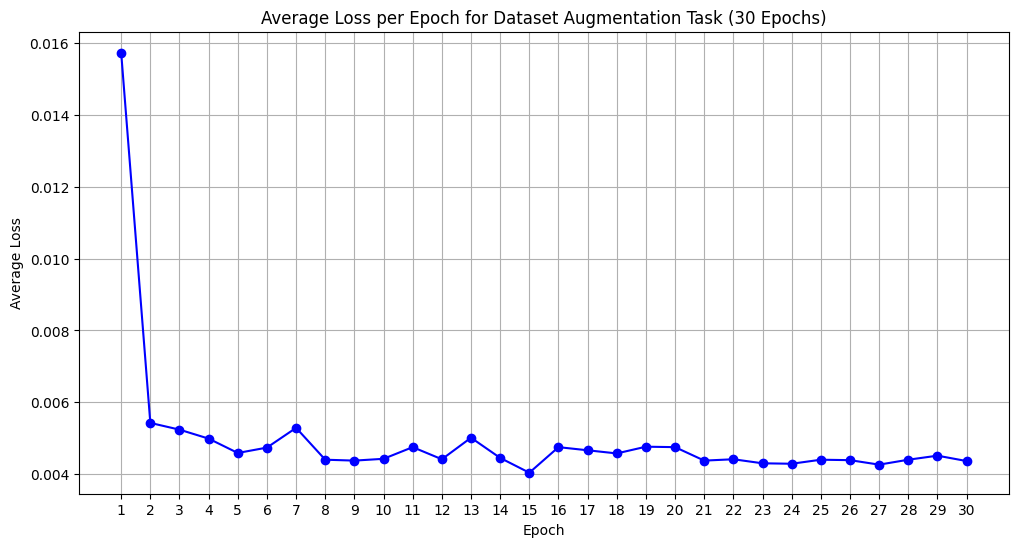

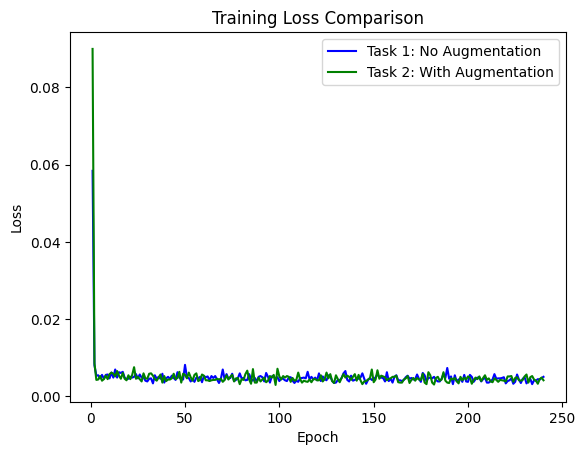

In [24]:

import matplotlib.pyplot as plt
loss_task_1 = [
    0.0584, 0.0080, 0.0053, 0.0054, 0.0046, 0.0055, 0.0045, 0.0055,  # Epoch 1
    0.0056, 0.0046, 0.0061, 0.0048, 0.0069, 0.0048, 0.0062, 0.0060,  # Epoch 2
    0.0063, 0.0048, 0.0044, 0.0045, 0.0050, 0.0048, 0.0050, 0.0057,  # Epoch 3
    0.0046, 0.0056, 0.0048, 0.0049, 0.0040, 0.0038, 0.0045, 0.0046,  # Epoch 4
    0.0033, 0.0054, 0.0045, 0.0050, 0.0045, 0.0058, 0.0035, 0.0046,  # Epoch 5
    0.0050, 0.0045, 0.0053, 0.0047, 0.0042, 0.0062, 0.0048, 0.0043,  # Epoch 6
    0.0043, 0.0081, 0.0049, 0.0047, 0.0038, 0.0044, 0.0037, 0.0048,  # Epoch 7
    0.0046, 0.0050, 0.0036, 0.0052, 0.0049, 0.0051, 0.0041, 0.0052,  # Epoch 8
    0.0047, 0.0052, 0.0043, 0.0034, 0.0045, 0.0069, 0.0043, 0.0057,  # Epoch 9
    0.0046, 0.0047, 0.0058, 0.0039, 0.0042, 0.0046, 0.0059, 0.0046,  # Epoch 10
    0.0047, 0.0041, 0.0042, 0.0057, 0.0044, 0.0040, 0.0047, 0.0038,  # Epoch 11
    0.0050, 0.0052, 0.0049, 0.0038, 0.0060, 0.0050, 0.0035, 0.0051,  # Epoch 12
    0.0052, 0.0045, 0.0049, 0.0039, 0.0046, 0.0045, 0.0041, 0.0039,  # Epoch 13
    0.0048, 0.0049, 0.0040, 0.0034, 0.0040, 0.0037, 0.0046, 0.0047,  # Epoch 14
    0.0048, 0.0046, 0.0063, 0.0044, 0.0050, 0.0043, 0.0048, 0.0041,  # Epoch 15
    0.0059, 0.0039, 0.0051, 0.0044, 0.0041, 0.0054, 0.0051, 0.0039,  # Epoch 16
    0.0034, 0.0035, 0.0042, 0.0041, 0.0047, 0.0059, 0.0065, 0.0042,  # Epoch 17
    0.0038, 0.0053, 0.0040, 0.0042, 0.0045, 0.0045, 0.0048, 0.0059,  # Epoch 18
    0.0045, 0.0032, 0.0042, 0.0047, 0.0042, 0.0043, 0.0049, 0.0057,  # Epoch 19
    0.0049, 0.0048, 0.0047, 0.0038, 0.0062, 0.0039, 0.0045, 0.0035,  # Epoch 20
    0.0050, 0.0054, 0.0041, 0.0041, 0.0039, 0.0042, 0.0049, 0.0053,  # Epoch 21
    0.0045, 0.0047, 0.0043, 0.0044, 0.0056, 0.0045, 0.0037, 0.0060,  # Epoch 22
    0.0054, 0.0038, 0.0048, 0.0047, 0.0046, 0.0050, 0.0042, 0.0038,  # Epoch 23
    0.0038, 0.0045, 0.0057, 0.0047, 0.0073, 0.0045, 0.0051, 0.0031,  # Epoch 24
    0.0054, 0.0038, 0.0043, 0.0045, 0.0037, 0.0055, 0.0038, 0.0037,  # Epoch 25
    0.0055, 0.0050, 0.0037, 0.0044, 0.0048, 0.0048, 0.0038, 0.0044,  # Epoch 26
    0.0048, 0.0035, 0.0035, 0.0039, 0.0043, 0.0057, 0.0045, 0.0046,  # Epoch 27
    0.0046, 0.0047, 0.0049, 0.0033, 0.0039, 0.0041, 0.0046, 0.0032,  # Epoch 28
    0.0037, 0.0056, 0.0043, 0.0034, 0.0045, 0.0049, 0.0033, 0.0039,  # Epoch 29
    0.0045, 0.0031, 0.0041, 0.0040, 0.0044, 0.0043, 0.0047, 0.0050   # Epoch 30
]

# Updated loss values from the dataset augmentation task (30 epochs)
loss_task_2 = [
    0.0900, 0.0085, 0.0042, 0.0043, 0.0052, 0.0040, 0.0044, 0.0053,  # Epoch 1
    0.0044, 0.0057, 0.0061, 0.0058, 0.0051, 0.0065, 0.0053, 0.0045,  # Epoch 2
    0.0060, 0.0045, 0.0041, 0.0054, 0.0044, 0.0055, 0.0075, 0.0045,  # Epoch 3
    0.0050, 0.0044, 0.0038, 0.0059, 0.0046, 0.0045, 0.0058, 0.0059,  # Epoch 4
    0.0053, 0.0044, 0.0040, 0.0048, 0.0056, 0.0035, 0.0052, 0.0039,  # Epoch 5
    0.0043, 0.0043, 0.0046, 0.0058, 0.0044, 0.0047, 0.0063, 0.0035,  # Epoch 6
    0.0058, 0.0055, 0.0046, 0.0061, 0.0049, 0.0040, 0.0055, 0.0059,  # Epoch 7
    0.0039, 0.0042, 0.0056, 0.0053, 0.0041, 0.0041, 0.0039, 0.0041,  # Epoch 8
    0.0042, 0.0042, 0.0045, 0.0043, 0.0045, 0.0037, 0.0042, 0.0054,  # Epoch 9
    0.0043, 0.0050, 0.0055, 0.0038, 0.0046, 0.0047, 0.0031, 0.0044,  # Epoch 10
    0.0042, 0.0057, 0.0066, 0.0043, 0.0032, 0.0070, 0.0035, 0.0035,  # Epoch 11
    0.0048, 0.0038, 0.0043, 0.0048, 0.0036, 0.0040, 0.0052, 0.0048,  # Epoch 12
    0.0055, 0.0029, 0.0071, 0.0051, 0.0043, 0.0052, 0.0048, 0.0052,  # Epoch 13
    0.0050, 0.0037, 0.0047, 0.0040, 0.0042, 0.0061, 0.0044, 0.0035,  # Epoch 14
    0.0040, 0.0038, 0.0037, 0.0043, 0.0036, 0.0044, 0.0044, 0.0041,  # Epoch 15
    0.0041, 0.0054, 0.0038, 0.0044, 0.0061, 0.0046, 0.0057, 0.0039,  # Epoch 16
    0.0034, 0.0054, 0.0044, 0.0036, 0.0047, 0.0057, 0.0048, 0.0053,  # Epoch 17
    0.0050, 0.0042, 0.0050, 0.0057, 0.0040, 0.0055, 0.0041, 0.0031,  # Epoch 18
    0.0038, 0.0039, 0.0043, 0.0046, 0.0069, 0.0036, 0.0043, 0.0067,  # Epoch 19
    0.0045, 0.0053, 0.0051, 0.0049, 0.0041, 0.0045, 0.0046, 0.0050,  # Epoch 20
    0.0050, 0.0053, 0.0036, 0.0035, 0.0035, 0.0043, 0.0046, 0.0052,  # Epoch 21
    0.0034, 0.0042, 0.0047, 0.0040, 0.0047, 0.0043, 0.0042, 0.0058,  # Epoch 22
    0.0035, 0.0031, 0.0062, 0.0054, 0.0035, 0.0030, 0.0047, 0.0050,  # Epoch 23
    0.0040, 0.0043, 0.0062, 0.0040, 0.0035, 0.0034, 0.0046, 0.0043,  # Epoch 24
    0.0047, 0.0039, 0.0033, 0.0050, 0.0041, 0.0048, 0.0043, 0.0051,  # Epoch 25
    0.0048, 0.0032, 0.0042, 0.0048, 0.0044, 0.0051, 0.0039, 0.0047,  # Epoch 26
    0.0054, 0.0042, 0.0046, 0.0038, 0.0036, 0.0046, 0.0042, 0.0037,  # Epoch 27
    0.0042, 0.0041, 0.0040, 0.0038, 0.0051, 0.0051, 0.0052, 0.0037,  # Epoch 28
    0.0047, 0.0049, 0.0041, 0.0040, 0.0042, 0.0051, 0.0056, 0.0035,  # Epoch 29
    0.0049, 0.0052, 0.0043, 0.0040, 0.0032, 0.0044, 0.0048, 0.0041   # Epoch 30
]

# Convert list into epochs and average loss for each epoch
epochs = list(range(1, 31))  # For 30 epochs
average_loss_per_epoch = [sum(loss_task_2[i*8:(i+1)*8])/8 for i in range(30)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, average_loss_per_epoch, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch for Dataset Augmentation Task (30 Epochs)')
plt.grid(True)
plt.xticks(epochs)
plt.show()


epochs = range(1, len(loss_task_1) + 1)

plt.plot(epochs, loss_task_1, label='Task 1: No Augmentation', color='blue')
plt.plot(epochs, loss_task_2, label='Task 2: With Augmentation', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()